# Final policy notebook
This notebook contains all code used for the report from the Gelderland analysts.
The notebook consists of the following parts: \
    - Loading the model \
    - Preliminary sensitivity analysis\
    - PRIM global sensitivity analysis and policy selection\
    - MOEA run with relevant convergence analysis\
    - Outcome policy evaluation plots

## Loading of model

In [32]:
import os
import random
import shutil
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    Policy,
    Scenario,
    ema_logging,
    Samplers,
    MultiprocessingEvaluator,
    save_results,
    load_results,
    Constraint,
)
from ema_workbench import Samplers
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.analysis import prim, parcoords
from ema_workbench.em_framework.optimization import to_problem, ArchiveLogger, EpsilonProgress
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Preliminary Sensitivity Analysis

This piece of analysis was conducted to get a general understanding of the model.\
Problem formulation 6 was used, this is a new problem formulation that disaggregates annual damages and deaths across locations.

In [33]:
dike_model, planning_steps = get_model_for_problem_formulation(6)
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

num_scens = 1024
policy = Policy("no release", **get_do_nothing_dict())

In [34]:
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=num_scens, policies = policy, uncertainty_sampling = Samplers.SOBOL)
#
# from ema_workbench import save_results
# save_results(results, f"{num_scens}_sen_SOBOL_np2.tar.gz")

In [35]:
results = load_results('1024_sen_SOBOL_np2.tar.gz')
experiments, outcomes = results

rings = ["A.1", "A.2", "A.3", "A.4", "A.5"]
data = pd.DataFrame(outcomes)

[MainProcess/INFO] results loaded successfully from C:\Users\larsk\Documents\Studie\Industrial_Ecology\Q4\MBDM\MBDM_GA\MBDM_GA\1024_sen_SOBOL_np2.tar.gz


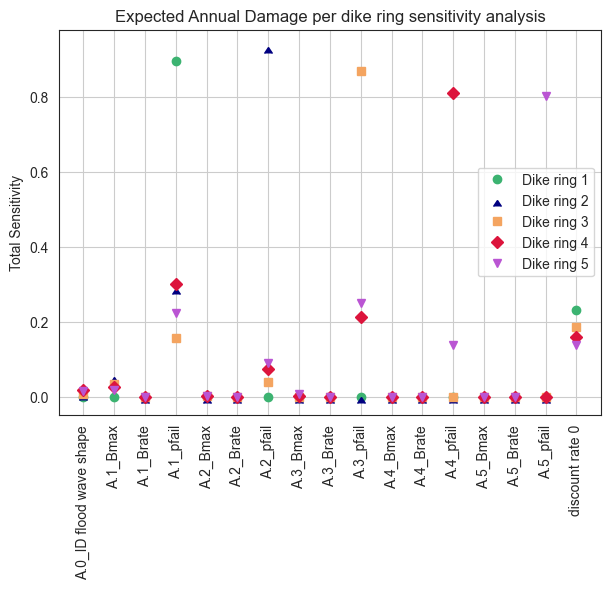

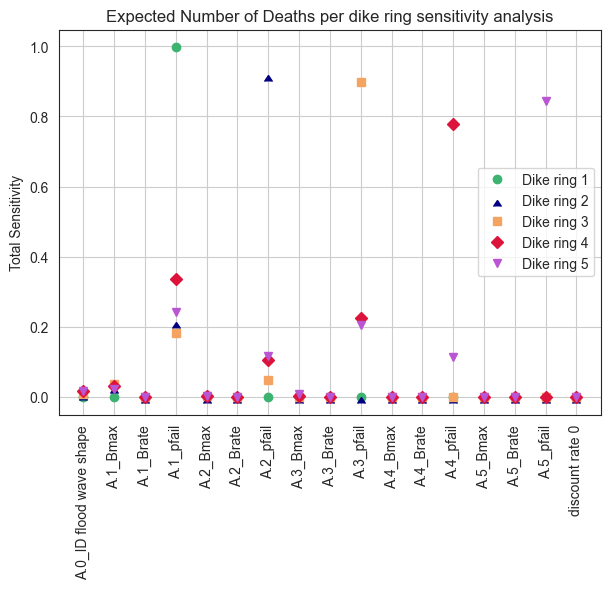

In [36]:
strings = ["_Expected Annual Damage", "_Expected Number of Deaths"]
cols = ["mediumseagreen", "navy", "sandybrown", "crimson", "mediumorchid"]
markers = ["o",6, "s", "D", "v"]
for j in range(len(strings)):
    for i in range(len(rings)):
        
        y = outcomes[f'{rings[i]}{strings[j]}']
        problem = get_SALib_problem(dike_model.uncertainties)
        Si = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)

        lst = Si.to_df()
        df = pd.concat(lst)
        if i == 0:
            ax = df.plot(y="ST", marker = markers[i], color = cols[i], linestyle = "", rot = 90, figsize = (7,5), label = f"Dike ring {i+1}")
        else:
            df.plot(y="ST", marker = markers[i], color = cols[i], linestyle = "", rot = 90, label = f"Dike ring {i+1}", ax=ax)
    
    ax.set_xticks(range(17))
    ax.set_xticklabels([ind for ind in df.index[:17]], rotation=90)
    ax.grid(visible = True)
    plt.title(f"{strings[j][1:]} per dike ring sensitivity analysis")
    plt.ylabel("Total Sensitivity")
    plt.savefig(f"./results/Sensitivity {strings[j][1:]}")
    plt.show()

Here, we can clearly see that the pfail parameters are by far the most influential, especially for their respective dike ring. A.1_pfail is also relevant for other dike rings. There is a lot of simularity between the two different plots, the main difference being the reliance on discount rate for the annual damages.

## PRIM global sensitivity analysis

Prim is used in this analysis to generate a reference scenario for the MOEA. To this end, we first set the problem formulation to 2, and run the model for roughly 36000 scenarios using sobol sampling.\
Then, we select the box that contains the top 5% of outcomes with the highest expected annual damage.\
From this range, we take the average value to obtain one reference scenario.

In [37]:
# Return policy for business-as-usual case
dike_model, planning_steps = get_model_for_problem_formulation(2)
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

bau_policy = Policy("no policy", **get_do_nothing_dict())

# Evaluate business-as-usual with SOBOL
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=1000, policies=bau_policy, uncertainty_sampling=Samplers.SOBOL)
# from ema_workbench import save_results
#
# save_results(results, "Base_scenario_pf2.tar.gz")

In [38]:
# Load results from previous run
results_bau = "Base_scenario_pf2.tar.gz"
experiments, outcomes = load_results(results_bau)

[MainProcess/INFO] results loaded successfully from C:\Users\larsk\Documents\Studie\Industrial_Ecology\Q4\MBDM\MBDM_GA\MBDM_GA\Base_scenario_pf2.tar.gz


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 36000 points remaining, containing 1793 cases of interest
[MainProcess/INFO] mean: 0.6513911620294599, mass: 0.050916666666666666, coverage: 0.6659230340211936, density: 0.6513911620294599 restricted_dimensions: 5


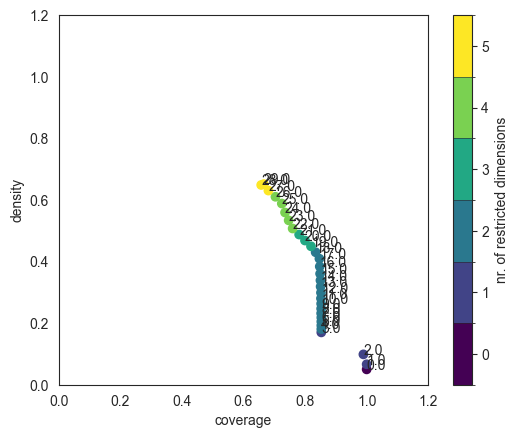

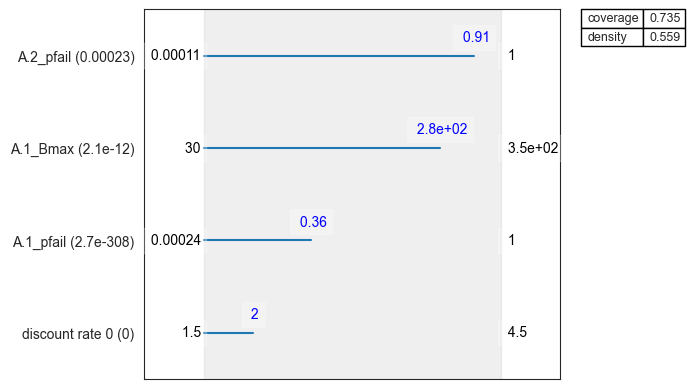

In [39]:
# Prim analysis for the 5% highest annual damage outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)
outcome_of_interest = outcomes['Expected Annual Damage']
x = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)
y = outcome_of_interest > np.percentile(outcome_of_interest, 95)
prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.06)
box = prim_alg.find_box()

box.show_tradeoff(annotated=True)
plt.show()

# Pick box 23, which has a relatively high density and interpretability
point = len(box.box_lims) - 6
box.inspect(point, style='graph')
box.select(point)
plt.savefig("results/PRIM range", bbox_inches = "tight", dpi = 200)
plt.show()

#box.resample(point)

From these results, we can see (as we would have expected from the prior sensitivity analysis, that the A.1_pfail parameter is by far the most important for the selection of the outcomes, and is therefore most restricted. The code below generates the reference scenario, and plots the prim result using a pairwise plot.

In [40]:
# Create reference scenario
lims_as_dict = box.box_lim.to_dict(orient="records")
for i in range(len(lims_as_dict)):
    del lims_as_dict[i]['discount rate 0']

av_dict = {}

for key in lims_as_dict[0].keys():
    av_dict[key] = (lims_as_dict[0][key] + lims_as_dict[1][key]) / 2
    if "Brate" in key or key == "A.0_ID flood wave shape":
        av_dict[key] = np.round(av_dict[key]).astype(int)

ref_scen = Scenario(**av_dict)

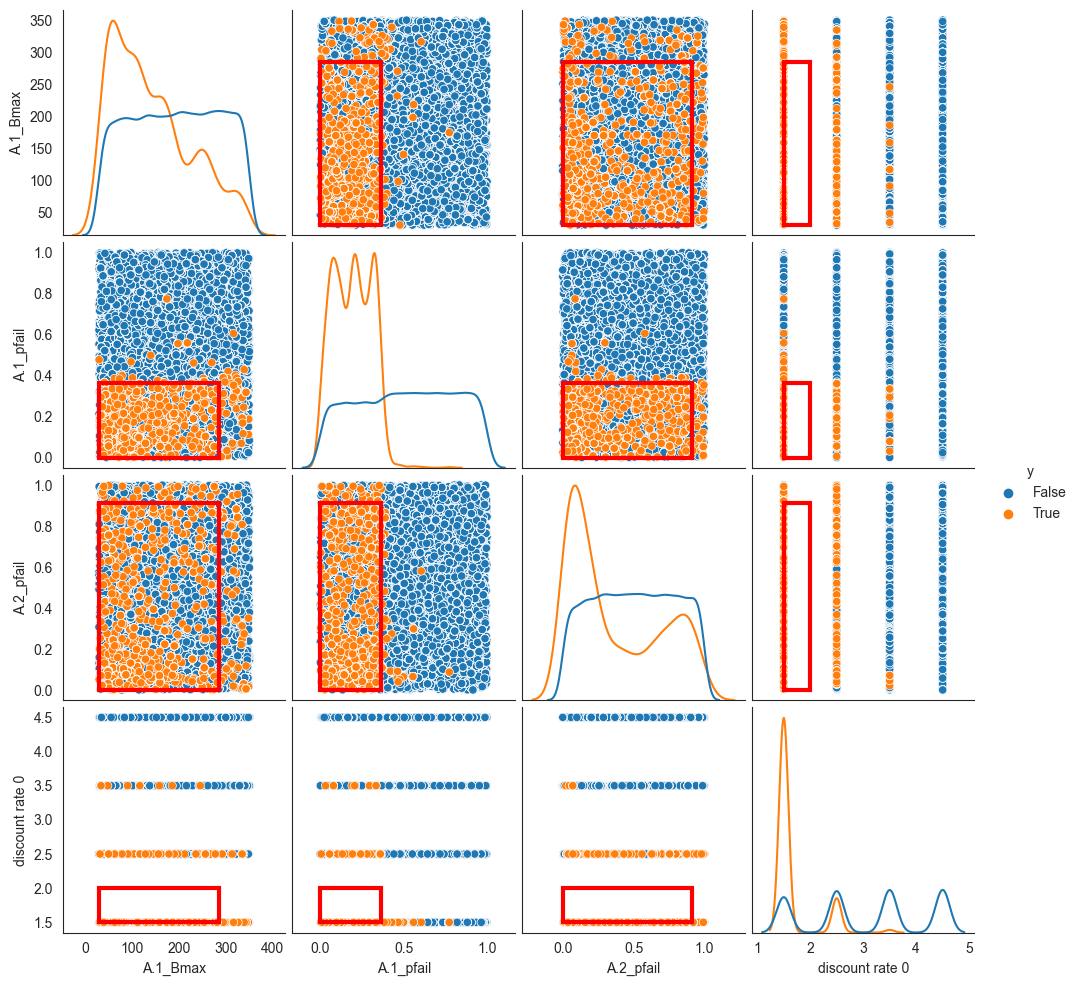

In [41]:
# Show scatter plot with cases of interest in box
box.show_pairs_scatter()
fig = plt.gcf()
plt.show()

## MOEA

The next step in the analysis is to use the MOEA algorithm to generate policies that perform best under this reference scenario.\
For this analysis, we perform 4 MOEA runs, each of 100,000 nfe's, to check for stochastisity.\ The specific values of $\epsilon$ are $10^6, 5 \times 10^7, 10^8, 10^6$ and $0.1$. These have been found using a trial and error method.\
Furthermore, the restriction of Annual damages < $5 \times 10^6$ is imposed to solve for low damage solutions.\
A fixed seed is chosen for reproducibility.\
The results of the MOEA are subsequently saved and shown in the figures below.

In [42]:
MOEA_runs = 4
results = []
convergences = []

nfes = 100000 
eps = [1e6, 5e7, 1e8, 1e6, 0.1] # Values are chosen to obtain ~5 solutions per run
constraints = [Constraint("max damages", outcome_names="Expected Annual Damage", function=lambda x: max(0, x - 5e6))] 

# Find policies in 5 different runs
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     for i in range(MOEA_runs):
#         if os.path.isdir('./tmp'):
#             shutil.rmtree('./tmp')
#
#         random.seed(i)  # Choose seed for reproducibility
#
#         # Save epsilon progress as convergence metric
#         convergence_metrics = [
#             ArchiveLogger(
#                 "./",
#                 [l.name for l in dike_model.levers],
#                 [o.name for o in dike_model.outcomes],
#                 base_filename=f"convergence_run{i}.tar.gz"),
#             EpsilonProgress()]
#
#         result, convergence = evaluator.optimize(
#             nfe=nfes,
#             searchover="levers",
#             epsilons=eps,
#             convergence=convergence_metrics,
#             constraints=constraints,
#             reference=ref_scen) # Uses the reference scenario obtained earlier with PRIM
#         results.append(result)
#         convergences.append(convergence)
#
# with open(f"convergences_final", "wb") as fp:   #Pickling
#     pickle.dump(convergences, fp)
#
# with open(f"results_final", "wb") as fp:   #Pickling
#     pickle.dump(results, fp)


The next cell loads the saved results and convergences, and saves the policies to a npy file.

In [43]:
# Show outcomes and save policy
with open(f"results_final", "rb") as fp:   #Unpickling
    results = pickle.load(fp)

with open(f"convergences_final", "rb") as fp:   # Unpickling
    convergences = pickle.load(fp)
outcome_keys = np.copy(list(outcomes.keys()))
MOEA_policies = np.array([{} for _ in range(MOEA_runs)])

for run in range(MOEA_runs):
    outcomes = results[run].loc[:,
               ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs',
                'Expected Number of Deaths']]

    # Save policies
    policies_df = results[run].drop(outcome_keys, axis=1)
    policies_dict = policies_df.to_dict(orient="records")
    MOEA_policies[run] = policies_dict

np.save(f"policies_final.npy", MOEA_policies)

The next functions plot the outcomes from the different MOEA runs, and their respective convergence.

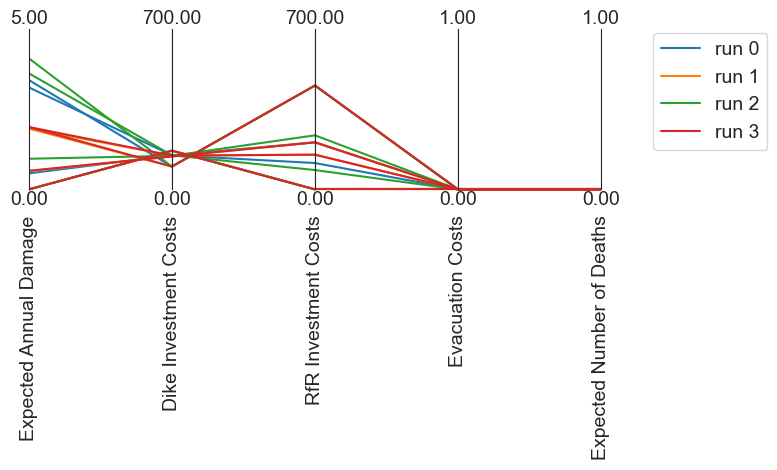

In [44]:
scale = 1e6
outcome_keys = np.copy(list(outcomes.keys()))
limits = pd.DataFrame([[0,0,0,0,0],[5,700,700,1,1]], columns=outcome_keys)
axes = parcoords.ParallelAxes(limits)

for i, (result, color) in enumerate(zip(results, sns.color_palette())):
    outcomes = result.loc[:,outcome_keys]
    # Scale costs to millions
    for key in outcome_keys:
        if key != 'Expected Number of Deaths':
            outcomes[key] = outcomes[key] / scale
    axes.plot(outcomes, color=color, label='run {}'.format(i))

axes.legend()
plt.savefig("results/MOEA runs", dpi = 200, bbox_inches = "tight")
plt.show()



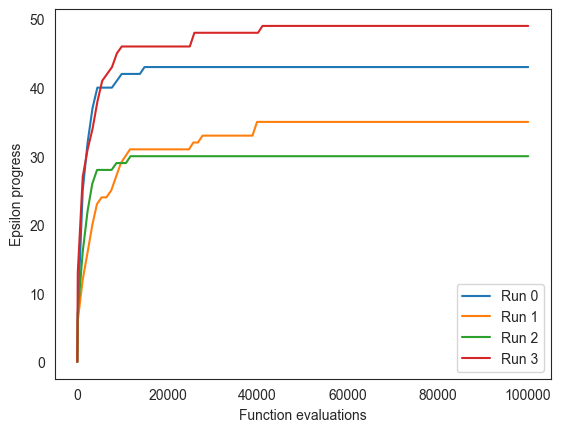

In [45]:
for i in range(len(convergences)):
    plt.plot(convergences[i].nfe, convergences[i].epsilon_progress, label = f"Run {i}")
plt.legend()
plt.xlabel("Function evaluations")
plt.ylabel("Epsilon progress")
plt.savefig("results/epsilon_convergences_final", dpi = 200, bbox_inches = "tight")
plt.show()


## Evaluate policies
Now that we have generated different policies with MOEA, we would like to analyse them, to see which ones perform best.\
There are a couple of steps that we take here.\
First, the policies are run for 1000 different scenarios.\
Then, the unique policies are selected from all policies, and both sets are shown in an imshow plot.\
Afterwards, some general results per policy are presented in their annual damages, annual deaths, and total investment costs.\
Finally, a signal to noise ratio is shown for each of the unique policies.

In [46]:
# Load policies
MOEA_runs = 4
policies_dict = np.load("policies_final.npy", allow_pickle=True)
pol_names = [f"pol_{100*i+j}" for i in range(MOEA_runs) for j in range(len(policies_dict[i]))]

### Plotting the obtained policies

In [47]:
num_scen = 1000
policies = [Policy(f"pol_{100*i+j}", **policies_dict[i][j]) for i in range(MOEA_runs) for j in range(len(policies_dict[i])) ]

dike_model, planning_steps = get_model_for_problem_formulation(2)
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results_new = evaluator.perform_experiments(num_scen, policies=policies)
# save_results(results_new, "re-evaluation.tar.gz")

Load the generated results.

In [48]:
results_new = load_results("re-evaluation.tar.gz")
exp_new, out_new = results_new

[MainProcess/INFO] results loaded successfully from C:\Users\larsk\Documents\Studie\Industrial_Ecology\Q4\MBDM\MBDM_GA\MBDM_GA\re-evaluation.tar.gz


This next function (rather elaborately) converts the policies from the different MOEA runs into one array, selects the unique policies, and plots both to give a clear overview of the different outcomes.\ The first table shows all policies, the second only unique policies.


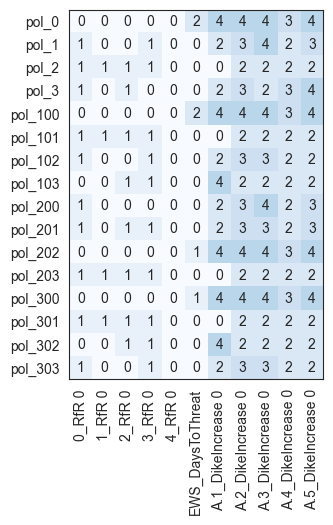

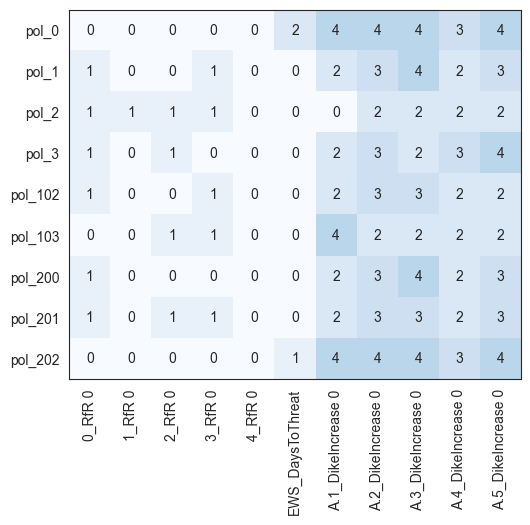

In [49]:
measures = [f"{j}_RfR 0" for j in range(5)] + ["EWS_DaysToThreat"] + [f"A.{i + 1}_DikeIncrease 0" for i in range(5)]
policies_list = []
for i in range(len(policies_dict)):
    policies_list.append(list(zip(*map(dict.values, policies_dict[i]))))

distance = 0
end_dist = 0

# Convert the 2D list with tuples into a table
pol_arr = np.zeros((len(measures), len(pol_names)))

for i in range(len(policies_list)):
    distance = end_dist
    for j in range(len(policies_list[i])):
        temp_dist = distance
        for k in range(len(policies_list[i][j])):
            #print(f"i{i} j{j} k{k} temp_dist{temp_dist}")
            pol_arr[j,temp_dist] = policies_list[i][j][k]
            temp_dist += 1
        end_dist = temp_dist

pol_arr = pol_arr.T

unique_pols = np.unique(pol_arr, axis = 0, return_index = True, return_inverse = True)
#sorting the array
un_ind = np.copy(unique_pols[1])
un_arr = np.copy(unique_pols[0])

ind = np.argsort(unique_pols[1])
unique_pols_arr = un_arr[ind]
unique_pols_ind = un_ind[ind]

# print
pol_nam_arr = np.array(pol_names)

it = 0
#Generating two plots, both showing the generated policies
for k in [pol_arr, unique_pols_arr]:
    for (j,i),label in np.ndenumerate(k):
        plt.text(i,j,int(label),ha='center',va='center')
    plt.imshow(k, cmap = "Blues", vmax = 14)
    plt.xticks(np.arange(len(measures)),measures,rotation = 90 )
    if it == 0:
        plt.yticks(np.arange(len(pol_names)), pol_names)
        plt.savefig("results/Policy_table_total", dpi = 200, bbox_inches = "tight")
    elif it == 1:
        plt.yticks(np.arange(len(pol_nam_arr[unique_pols_ind])), pol_nam_arr[unique_pols_ind])
        plt.savefig("results/Policy_table_unique", dpi = 200, bbox_inches = "tight")
    plt.show()
    it += 1


Now that the unique policies are selected, we generate results for the total annual damages, deaths, and investment costs in the next three function blocks.\
The evacuation costs are not considered in this report, as they were generally not high enough to have a large impact.

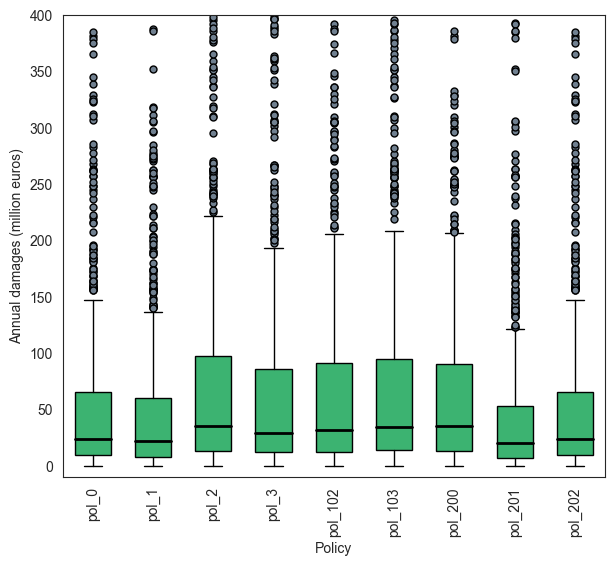

In [50]:
# Plot damages with a boxplot per policy
scale = 1e6

outcome = "Expected Annual Damage"
num_pols = len(policies)
plt.figure(figsize = (7,6))
expected_damages_per_pol = np.zeros((num_scen,len(policies)))
rel_pos = 1
for i in range(len(policies)):
    
    expected_damages_per_pol[:,i] = out_new[outcome][i*num_scen:(i+1)*num_scen]
    if i in unique_pols[1]:
        plt.boxplot(expected_damages_per_pol[:,i]/scale, widths = 0.6, positions = [rel_pos], medianprops = dict(color = "black", linewidth = 2),
            patch_artist = True,
            boxprops = dict(facecolor = "mediumseagreen"), flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'slategrey'})
        rel_pos += 1
plt.ylabel("Annual damages (million euros)")
plt.xlabel("Policy")
plt.xticks(ticks = np.arange(1, len(unique_pols[1])+1),labels = pol_nam_arr[unique_pols_ind], rotation = 90)
plt.savefig("results/Annual_damages_appendix", dpi = 200, bbox_inches = "tight")
plt.ylim(-10,400)
plt.savefig("results/Annual_damages_final", dpi = 200, bbox_inches = "tight")
plt.show()

Two figures are saved in the code above, as there are a lot of outliers in this barplot. For better readability, a deprecation is made around 400 million euros. The total figure is generated for the appendix. For interpretations of these figures, see the final report.

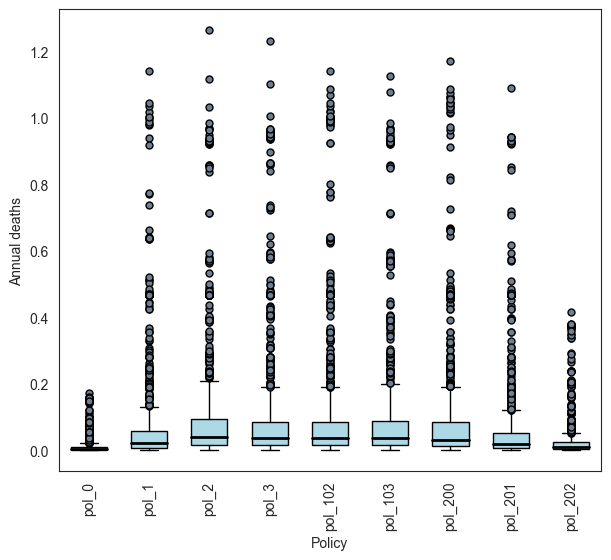

In [51]:
# Plot deaths with a boxplot per policy
outcome = "Expected Number of Deaths"
num_pols = len(policies)
plt.figure(figsize = (7,6))
expected_deaths_per_pol = np.zeros((num_scen,len(policies)))
rel_pos = 1
for i in range(len(policies)):
    
    expected_deaths_per_pol[:,i] = out_new[outcome][i*num_scen:(i+1)*num_scen]
    if i in unique_pols[1]:
        plt.boxplot(expected_deaths_per_pol[:,i], widths = 0.6, positions = [rel_pos], medianprops = dict(color = "black", linewidth = 2),
            patch_artist = True,
            boxprops = dict(facecolor = "lightblue"), flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'slategrey'})
        rel_pos += 1
plt.ylabel("Annual deaths")
plt.xlabel("Policy")
plt.xticks(ticks = np.arange(1, len(unique_pols[1])+1),labels = pol_nam_arr[unique_pols_ind], rotation = 90)
plt.ylabel("Annual deaths")
plt.xlabel("Policy")
plt.savefig("results/Annual_deaths_final", dpi = 200, bbox_inches = "tight")
plt.show()

As shown, there are a few policies (0 and 202) that perform way better than others.

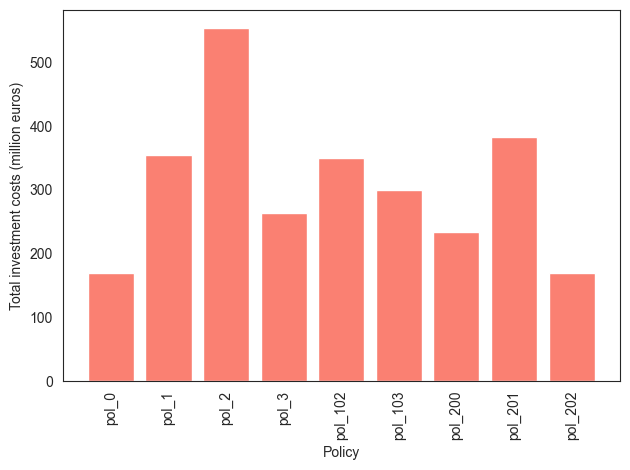

In [52]:
investments_per_pol = np.zeros((num_scen,len(policies)))
investments = ['Dike Investment Costs', 'RfR Investment Costs']
x = 1
scale = 1e6
for i in range(len(policies)):
    for j in investments:
        investments_per_pol[:,i] += out_new[j][i*num_scen:(i+1)*num_scen]
    if i in unique_pols[1]:
        plt.bar(x,investments_per_pol[0,i]/scale, color = "salmon")
        x += 1
plt.xticks(ticks = np.arange(1, len(unique_pols[1])+1),labels = pol_nam_arr[unique_pols_ind], rotation = 90)
plt.ylabel("Total investment costs (million euros)")
plt.xlabel("Policy")
plt.savefig("results/Total_investment_final", dpi = 200, bbox_inches = "tight")
plt.tight_layout()
plt.show()

The different investment costs are expected to be constant across scenarios.

### Robustness: Signal to noise
Lastly, a signal to noise ratio was calculated for each of the different scenarios.\
Because all of the outcomes are minimisation functions, this ratio is simply expressed as the mean x std of each of the policies over the 1000 scenarios.\
Subsequently, the data is normalised for readability. It should be noted that the RfR costs did not have a standard deviation at all, and are therefore all set to 0.5 for readability.

In [53]:
from ema_workbench import ScalarOutcome

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [54]:
overall_scores = {}
overall_outcomes = {}
for policy in pol_nam_arr[unique_pols[1]]:
    scores = {}
    outcomes = {}
    logical = exp_new['policy']==policy

    for outcome in dike_model.outcomes:
        value  = out_new[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
        outcomes[outcome.name] = value
    overall_scores[policy] = scores
    overall_outcomes[policy] = outcomes
scores = pd.DataFrame.from_dict(overall_scores).T
outs = pd.DataFrame.from_dict(overall_outcomes).T 

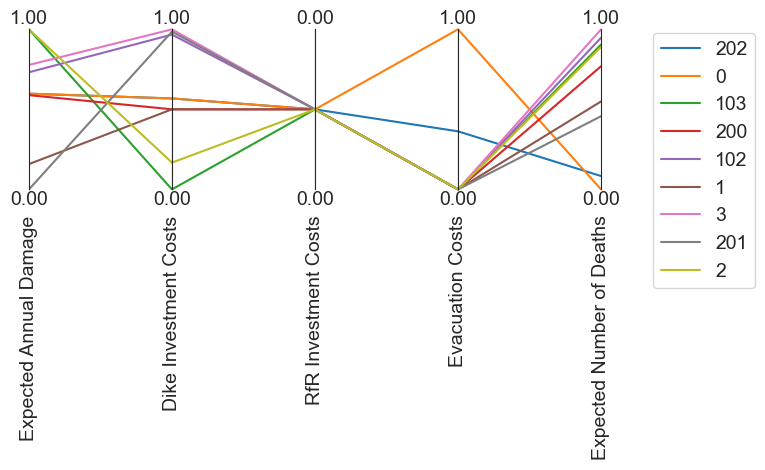

In [55]:
from ema_workbench.analysis import parcoords
#print(scores)
df = scores
data=(df-df.min())/(df.max()-df.min())
limits = parcoords.get_limits(data)
data = data.fillna(0.5)
limits.loc[0, [outcome.name for outcome in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
it = 0
palette = sns.color_palette("tab10",len(unique_pols_ind))
#print(palette)
for index, row in data.iterrows():
    color = palette[it]
    paraxes.plot(row, color = color, label = index[4:])
    it += 1
paraxes.legend()
plt.savefig("results/Robustness_final",dpi = 200, bbox_inches = "tight")
plt.show()


An interpretation of the robustness check and all other results can be found in the final report.